<a href="https://colab.research.google.com/github/piniii28/TRABAJO_FINAL_/blob/main/Entrega_Trabajo_final.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
%matplotlib inline
import xarray as xr
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import sklearn
import sklearn.ensemble
import scipy.stats
from sklearn.model_selection import train_test_split
from tqdm import tqdm
import xarray as xr
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import sklearn
import sklearn.ensemble
import scipy.stats
from sklearn.model_selection import train_test_split
import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from scipy.stats import pearsonr
from sklearn.metrics import mean_squared_error

In [ ]:
#Download the required packages and the data that we will use
#for this tutorial

!pip install netCDF4
# !wget http://portal.nersc.gov/project/dasrepo/AGU_ML_Tutorial/sst.mon.mean.trefadj.anom.1880to2018.nc
# !wget http://portal.nersc.gov/project/dasrepo/AGU_ML_Tutorial/nino34.long.anom.data.txt

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.1/9.1 MB 60.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 59.9 MB/s eta 0:00:00


In [ ]:
#Download Nino3.4 index (this index measures the state of ENSO by encoding the average
#temperature anomaly in the equatorial Pacific)
!gdown --id 1aGvitA8rYrHRDxNd2XD4AAFsahCQsv0t

/usr/local/lib/python3.10/dist-packages/gdown/__main__.py:140: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From: https://drive.google.com/uc?id=1aGvitA8rYrHRDxNd2XD4AAFsahCQsv0t
To: /content/nino34.long.anom.data.txt
100% 15.4k/15.4k [00:00<00:00, 29.0MB/s]


In [ ]:
#Download sst observations from 1880 to 2018
!gdown 1-xefk3imP4Q-8GevIV2YIo82iP5rTdSc

Downloading...
From (original): https://drive.google.com/uc?id=1-xefk3imP4Q-8GevIV2YIo82iP5rTdSc
From (redirected): https://drive.google.com/uc?id=1-xefk3imP4Q-8GevIV2YIo82iP5rTdSc&confirm=t&uuid=be80d1b8-6c35-4b12-8953-2699cf7bce45
To: /content/sst.mon.mean.trefadj.anom.1880to2018.nc
100% 432M/432M [00:04<00:00, 90.1MB/s]


In [ ]:
#Scaffold code to load in data.  This code cell is mostly data wrangling

def load_enso_indices():
  """
  Reads in the txt data file to output a pandas Series of ENSO vals

  outputs
  -------

    pd.Series : monthly ENSO values starting from 1870-01-01
  """
  with open('nino34.long.anom.data.txt') as f:
    line = f.readline()
    enso_vals = []
    while line:
        yearly_enso_vals = map(float, line.split()[1:])
        enso_vals.extend(yearly_enso_vals)
        line = f.readline()

  enso_vals = pd.Series(enso_vals)
  enso_vals.index = pd.date_range('1870-01-01',freq='MS',
                                  periods=len(enso_vals))
  enso_vals.index = pd.to_datetime(enso_vals.index)
  return enso_vals

def assemble_basic_predictors_predictands(start_date, end_date, lead_time,
                                    use_pca=False, n_components=32):
  """
  inputs
  ------

      start_date        str : the start date from which to extract sst
      end_date          str : the end date
      lead_time         str : the number of months between each sst
                              value and the target Nino3.4 Index
      use_pca          bool : whether or not to apply principal components
                              analysis to the sst field
      n_components      int : the number of components to use for PCA

  outputs
  -------
      Returns a tuple of the predictors (np array of sst temperature anomalies)
      and the predictands (np array the ENSO index at the specified lead time).

  """
  ds = xr.open_dataset('sst.mon.mean.trefadj.anom.1880to2018.nc')
  sst = ds['sst'].sel(time=slice(start_date, end_date))
  num_time_steps = sst.shape[0]

  #sst is a 3D array: (time_steps, lat, lon)
  #in this tutorial, we will not be using ML models that take
  #advantage of the spatial nature of global temperature
  #therefore, we reshape sst into a 2D array: (time_steps, lat*lon)
  #(At each time step, there are lat*lon predictors)
  sst = sst.values.reshape(num_time_steps, -1)
  sst[np.isnan(sst)] = 0

  #Use Principal Components Analysis, also called
  #Empirical Orthogonal Functions, to reduce the
  #dimensionality of the array
  if use_pca:
    #TODO: create an option to apply the PCA operation learned
    #on the train set to the test set.  Currently, PCA is performed
    #independently on the train set and test set.
    pca = sklearn.decomposition.PCA(n_components=n_components)
    pca.fit(sst)
    X = pca.transform(sst)
  else:
    X = sst

  start_date_plus_lead = pd.to_datetime(start_date) + \
                        pd.DateOffset(months=lead_time)
  end_date_plus_lead = pd.to_datetime(end_date) + \
                      pd.DateOffset(months=lead_time)
  y = load_enso_indices()[slice(start_date_plus_lead,
                                end_date_plus_lead)]


  ds.close()
  return X, y

def plot_nino_time_series(y, predictions, title):
  """
  inputs
  ------
    y           pd.Series : time series of the true Nino index
    predictions np.array  : time series of the predicted Nino index (same
                            length and time as y)
    titile                : the title of the plot

  outputs
  -------
    None.  Displays the plot
  """
  predictions = pd.Series(predictions, index=y.index)
  predictions = predictions.sort_index()
  y = y.sort_index()

  plt.plot(y, label='Ground Truth')
  plt.plot(predictions, '--', label='ML Predictions')
  plt.legend(loc='best')
  plt.title(title)
  plt.ylabel('Nino3.4 Index')
  plt.xlabel('Date')
  plt.show()
  plt.close()

## Ejercicio de desafío: ¿Qué fuentes de datos mejoran el algoritmo ML? ¿Qué fuentes de datos no mejoran el algoritmo ML?

Intentemos entrenar nuestro modelo de pronóstico de ENSO con datos antiguos (es decir, de principios de la década de 1900) del conjunto de datos de SST de Cobe. Hay mucha más incertidumbre con estos datos que con los datos más nuevos, ya que la aparición de la teledetección y las fuentes de datos han mejorado.

**OBJETIVO DE ESTE EJERCICIO:** generar dos gráficos: uno que muestre la serie temporal de índices predichos y verdaderos de Niño3.4 con un modelo ML entrenado con datos de 1900-1930. El otro debe mostrar lo mismo (serie temporal de índices predichos y verdaderos de Niño3.4 con un modelo entrenado con datos de 1975-2005). (Ambos algoritmos entrenados deben probarse con datos de 2007-2018).

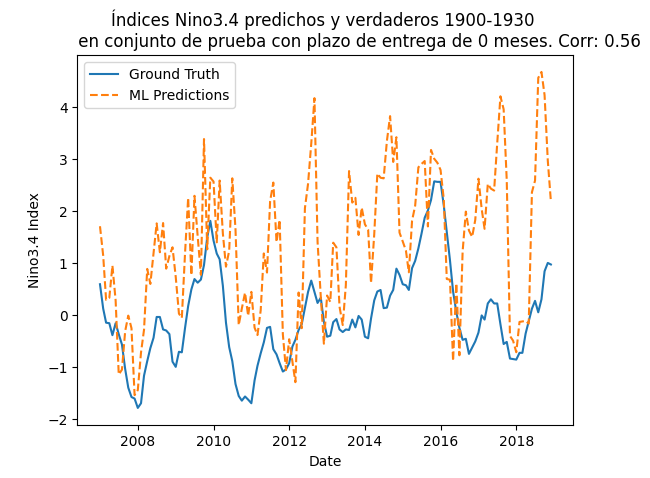

In [ ]:

lead_time = 0

# Ensamblar datos con un rango de fechas ajustado
X_train, y_train = assemble_basic_predictors_predictands('1900-01-01', '1930-12-31', lead_time=lead_time)
X_test, y_test = assemble_basic_predictors_predictands('2007-01-01', '2018-12-31', lead_time=lead_time)

regr = sklearn.linear_model.LinearRegression()
regr.fit(X_train, y_train)

predictions_test = regr.predict(X_test)
corr, _ = scipy.stats.pearsonr(predictions_test, y_test)

plot_nino_time_series(y_test, predictions_test,
            'Índices Nino3.4 predichos y verdaderos 1900-1930 \n \
            en conjunto de prueba con plazo de entrega de 0 meses. Corr: {:.2f}'.format(corr))

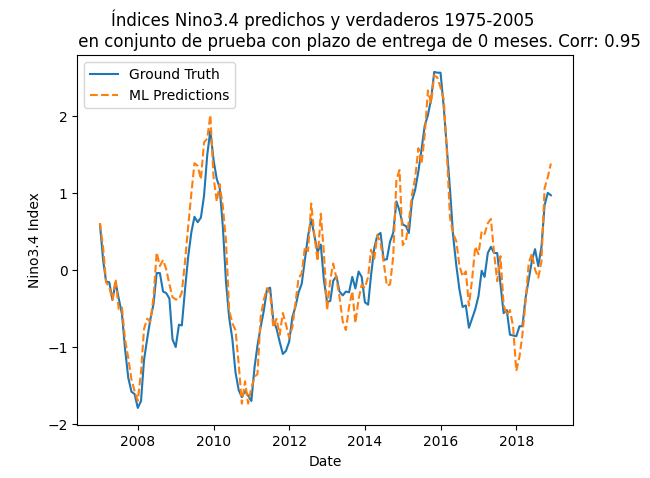

In [ ]:
lead_time = 0

# Ensamblar datos con un rango de fechas ajustado
X_train, y_train = assemble_basic_predictors_predictands('1975-01-01', '2005-12-31', lead_time=lead_time)
X_test, y_test = assemble_basic_predictors_predictands('2007-01-01', '2018-12-31', lead_time=lead_time)

regr = sklearn.linear_model.LinearRegression()
regr.fit(X_train, y_train)

predictions_test = regr.predict(X_test)
corr, _ = scipy.stats.pearsonr(predictions_test, y_test)

plot_nino_time_series(y_test, predictions_test,
            'Índices Nino3.4 predichos y verdaderos 1975-2005 \n \
            en conjunto de prueba con plazo de entrega de 0 meses. Corr: {:.2f}'.format(corr))

##Regresión Ridge con regularización

##1900-1930

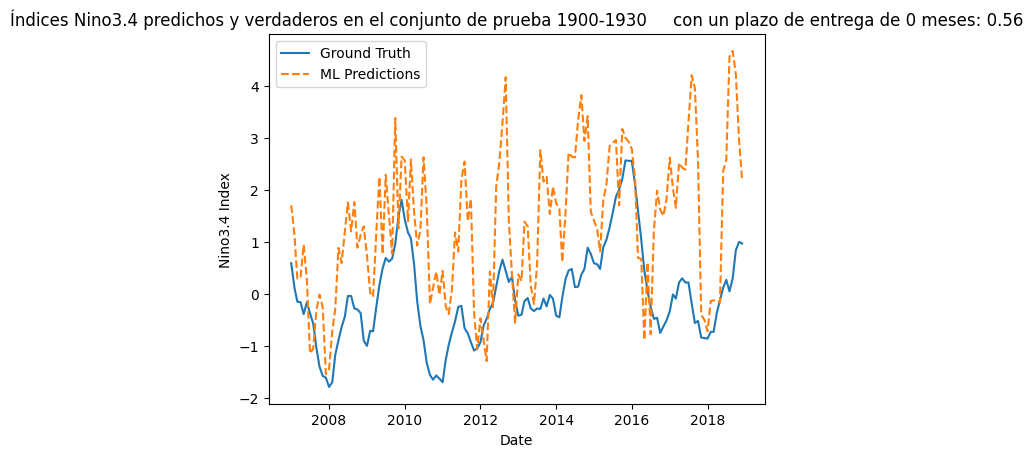

In [ ]:
lead_time = 0

# Ensamblar datos con un rango de fechas ajustado
X_train, y_train = assemble_basic_predictors_predictands('1900-01-01', '1930-12-31', lead_time=lead_time)
X_test, y_test = assemble_basic_predictors_predictands('2007-01-01', '2018-12-31', lead_time=lead_time)

regr_1_month_prim = sklearn.linear_model.LinearRegression()
regr_1_month_prim.fit(X_train,y_train)

#First, let's plot the performance of the model
predictions_test = regr_1_month_prim.predict(X_test)
corr, _ = scipy.stats.pearsonr(predictions_test, y_test)
plot_nino_time_series(y_test, predictions_test,
    'Índices Nino3.4 predichos y verdaderos en el conjunto de prueba 1900-1930 \
    con un plazo de entrega de 0 meses: {:.2f}'.format(corr))

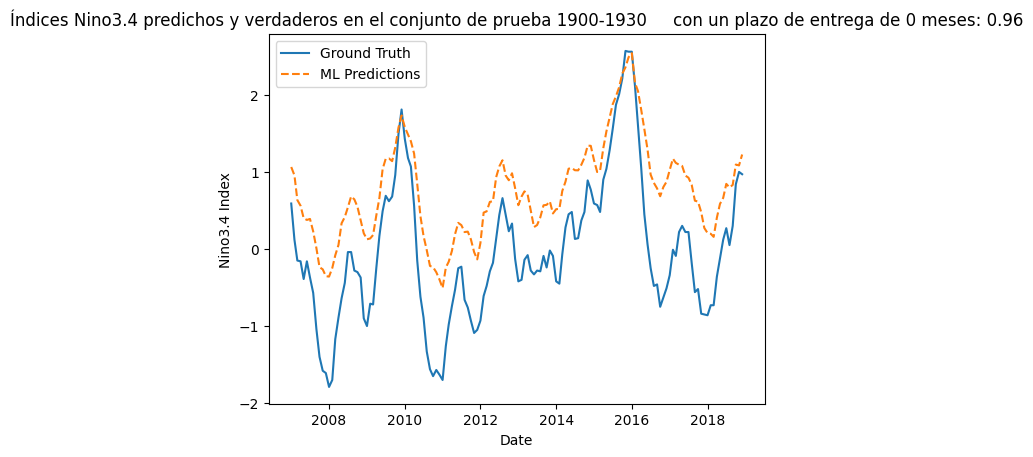

In [ ]:
# Ensamblar datos con un rango de fechas ajustado
X_train, y_train = assemble_basic_predictors_predictands('1900-01-01', '1930-12-31', lead_time=lead_time)
X_test, y_test = assemble_basic_predictors_predictands('2007-01-01', '2018-12-31', lead_time=lead_time)

regr_1_month_ridge_prim = sklearn.linear_model.Ridge(alpha=80000.0)
regr_1_month_ridge_prim.fit(X_train,y_train)

#First, let's plot the performance of the model
predictions_test = regr_1_month_ridge_prim.predict(X_test)
corr, _ = scipy.stats.pearsonr(predictions_test, y_test)
plot_nino_time_series(y_test, predictions_test,
    'Índices Nino3.4 predichos y verdaderos en el conjunto de prueba 1900-1930 \
    con un plazo de entrega de 0 meses: {:.2f}'.format(corr))

##1975-2005

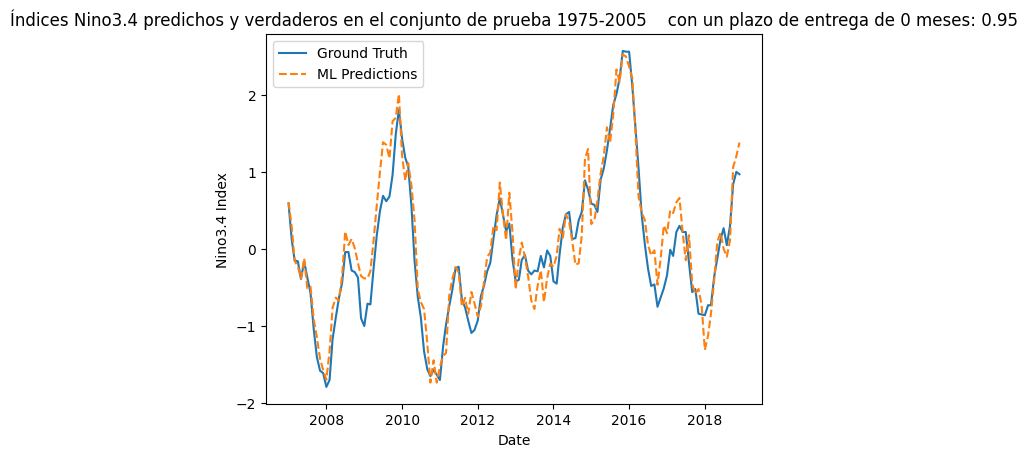

In [ ]:
 lead_time = 0
#Ensamblar datos con un rango de fechas ajustado
X_train, y_train = assemble_basic_predictors_predictands('1975-01-01', '2005-12-31', lead_time=lead_time)
X_test, y_test = assemble_basic_predictors_predictands('2007-01-01', '2018-12-31', lead_time=lead_time)

regr_1_month_seg = sklearn.linear_model.LinearRegression()
regr_1_month_seg.fit(X_train,y_train)

#First, let's plot the performance of the model
predictions_test = regr_1_month_seg.predict(X_test)
corr, _ = scipy.stats.pearsonr(predictions_test, y_test)
plot_nino_time_series(y_test, predictions_test,
    'Índices Nino3.4 predichos y verdaderos en el conjunto de prueba 1975-2005 \
    con un plazo de entrega de 0 meses: {:.2f}'.format(corr))


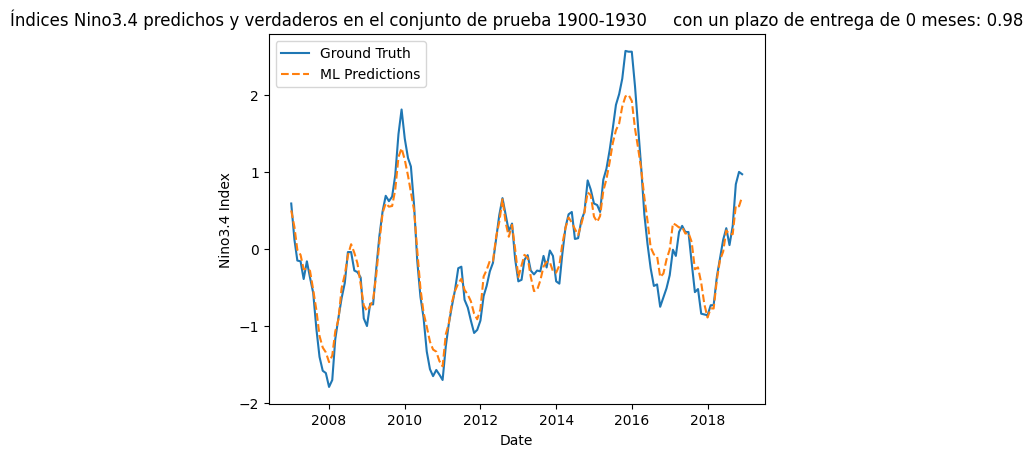

In [ ]:
lead_time = 0

# Ensamblar datos con un rango de fechas ajustado
X_train, y_train = assemble_basic_predictors_predictands('1975-01-01', '2005-12-31', lead_time=lead_time)
X_test, y_test = assemble_basic_predictors_predictands('2007-01-01', '2018-12-31', lead_time=lead_time)

regr_1_month_ridge_seg = sklearn.linear_model.Ridge(alpha=80000.0)
regr_1_month_ridge_seg.fit(X_train,y_train)

#First, let's plot the performance of the model
predictions_test = regr_1_month_ridge_seg.predict(X_test)
corr, _ = scipy.stats.pearsonr(predictions_test, y_test)
plot_nino_time_series(y_test, predictions_test,
    'Índices Nino3.4 predichos y verdaderos en el conjunto de prueba 1900-1930 \
    con un plazo de entrega de 0 meses: {:.2f}'.format(corr))

##MODELO ML


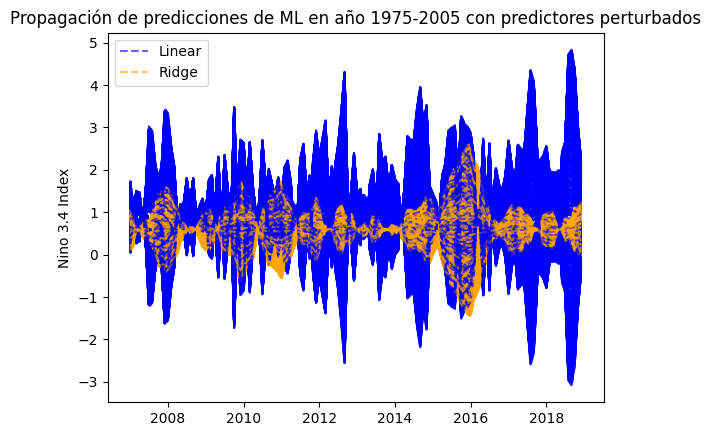

In [ ]:
"""In this cell, we will visualize the variance of linear regression and ridge regression"""
for experiment_num in range(1000):
  perturbed_X_test = X_test * np.random.uniform(-1.05,1.05)

  perturbed_predictions_linear = regr_1_month_prim.predict(perturbed_X_test)
  perturbed_predictions_linear = pd.Series(perturbed_predictions_linear,
                                           index=y_test.index)
  plt.plot(perturbed_predictions_linear, '--', label='Linear', color='blue',
           alpha=0.6)

  perturbed_predictions_ridge = regr_1_month_ridge_prim.predict(perturbed_X_test)
  perturbed_predictions_ridge = pd.Series(perturbed_predictions_ridge,
                                           index=y_test.index)
  plt.plot(perturbed_predictions_ridge, '--', label='Ridge', color='orange',
           alpha=0.6)

  if experiment_num == 0: plt.legend(loc='best')

plt.title("Propagación de predicciones de ML en año 1975-2005 con predictores perturbados")
plt.ylabel("Nino 3.4 Index")
plt.show()

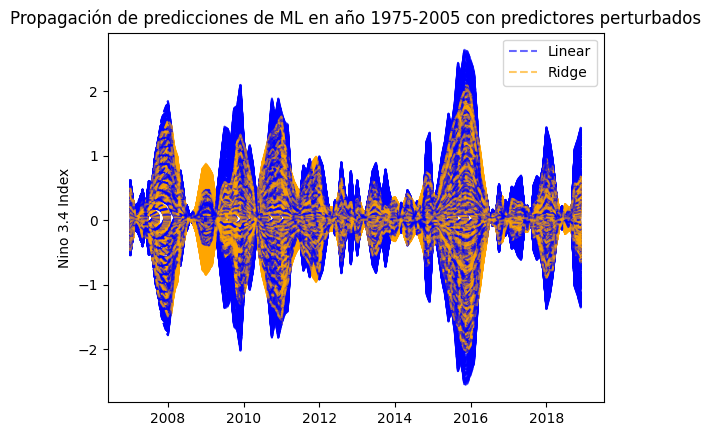

In [ ]:
"""In this cell, we will visualize the variance of linear regression and ridge regression"""
for experiment_num in range(1000):
  perturbed_X_test = X_test * np.random.uniform(-1.05,1.05)

  perturbed_predictions_linear = regr_1_month_seg.predict(perturbed_X_test)
  perturbed_predictions_linear = pd.Series(perturbed_predictions_linear,
                                           index=y_test.index)
  plt.plot(perturbed_predictions_linear, '--', label='Linear', color='blue',
           alpha=0.6)

  perturbed_predictions_ridge = regr_1_month_ridge_seg.predict(perturbed_X_test)
  perturbed_predictions_ridge = pd.Series(perturbed_predictions_ridge,
                                           index=y_test.index)
  plt.plot(perturbed_predictions_ridge, '--', label='Ridge', color='orange',
           alpha=0.6)

  if experiment_num == 0: plt.legend(loc='best')

plt.title("Propagación de predicciones de ML en año 1975-2005 con predictores perturbados")
plt.ylabel("Nino 3.4 Index")
plt.show()

#Ejercicio de desafío: Manipulación de datos: ¿Los algoritmos de aprendizaje automático funcionan mejor con un problema de clasificación o de regresión?

Convierta el problema de regresión (predicción de un valor continuo) a clasificación (predicción de un valor discreto). En este caso, el valor continuo es el valor exacto del índice Niño3.4.

Agrupemos el índice Niño3.4 en dos valores: 0 y 1. Supongamos que los valores negativos del índice Niño3.4 se deben asignar a 0 y los valores positivos del índice se deben asignar a 1.
Objetivo del ejercicio:

¡Entrene una red neuronal y un modelo de regresión logística de sklearn para predecir 0 o 1 correspondientes a la asignación anterior! ¡Intente cambiar la función de pérdida de la red neuronal de nn.MSELoss a nn.BCEWithLogitsLoss!

In [ ]:
# Instalar bibliotecas necesarias
!pip install netCDF4 xarray pandas numpy matplotlib scikit-learn torch torchvision

# Descargar los datos necesarios
!wget http://portal.nersc.gov/project/dasrepo/AGU_ML_Tutorial/sst.mon.mean.trefadj.anom.1880to2018.nc
!wget http://portal.nersc.gov/project/dasrepo/AGU_ML_Tutorial/nino34.long.anom.data.txt

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.1/9.1 MB 21.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 22.7 MB/s eta 0:00:00
--2025-01-15 03:41:28--  http://portal.nersc.gov/project/dasrepo/AGU_ML_Tutorial/sst.mon.mean.trefadj.anom.1880to2018.nc
Resolving portal.nersc.gov (portal.nersc.gov)... 128.55.206.106, 128.55.206.107, 128.55.206.108, ...
Connecting to portal.nersc.gov (portal.nersc.gov)|128.55.206.106|:80... connected.
HTTP request sent, awaiting response... 308 Permanent Redirect
Location: https://portal.nersc.gov/project/dasrepo/AGU_ML_Tutorial/sst.mon.mean.trefadj.anom.1880to2018.nc [following]
--2025-01-15 03:41:29--  https://portal.nersc.gov/project/dasrepo/AGU_ML_Tutorial/sst.mon.mean.trefadj.anom.1880to2018.nc
Connecting to portal.nersc.gov (portal.nersc.gov)|128.55.206.106|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 432481041 (412M) [application/x-netcdf]
Saving to: ‘sst.mon.mean.trefadj.anom.1880to2018.nc’

sst.

In [ ]:
import xarray as xr
import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.metrics import mean_squared_error, accuracy_score
from scipy.stats import pearsonr
import matplotlib.pyplot as plt

# Función para cargar el índice ENSO desde el archivo
def load_enso_indices():
    """
    Carga los valores del índice Niño 3.4 desde el archivo .txt y los devuelve como una serie de pandas.
    """
    with open('nino34.long.anom.data.txt') as f:
        lines = f.readlines()[1:]
        enso_vals = []
        for line in lines:
            yearly_vals = map(float, line.split()[1:])
            enso_vals.extend(yearly_vals)
    enso_vals = pd.Series(enso_vals)
    enso_vals.index = pd.date_range('1870-01-01', freq='MS', periods=len(enso_vals))
    return enso_vals

# Función para ensamblar predictores y predictandos
def assemble_predictors_predictands(start_date, end_date, lead_time):
    """
    Carga las anomalías de temperatura superficial del mar y genera los predictores y predictandos
    para el rango de fechas especificado.
    """
    # Cargar el dataset SST
    ds = xr.open_dataset('sst.mon.mean.trefadj.anom.1880to2018.nc')
    sst = ds['sst'].sel(time=slice(start_date, end_date)).fillna(0)

    # Aplanar el dataset (lat, lon) para que sea compatible con ML
    X = sst.values.reshape(sst.shape[0], -1)

    # Generar el índice Niño 3.4 como predictando
    enso = load_enso_indices()
    y = enso[slice(pd.to_datetime(start_date) + pd.DateOffset(months=lead_time),
                   pd.to_datetime(end_date) + pd.DateOffset(months=lead_time))].values
    return X, y

In [ ]:
# Función para convertir valores continuos a categorías (clasificación)
def categorize_nino(y):
    """
    Convierte los valores continuos del índice Niño 3.4 a categorías:
    - 0: Neutral
    - 1: La Niña
    - 2: El Niño
    """
    y_classification = np.zeros_like(y)
    y_classification[y > 0.5] = 2  # El Niño
    y_classification[y < -0.5] = 1  # La Niña
    return y_classification


In [ ]:
# Definir los rangos de fechas
train_start, train_end = '1980-01-01', '2005-12-31'
test_start, test_end = '2007-01-01', '2017-12-31'
lead_time = 3

# Generar predictores y predictandos
X_train, y_train = assemble_predictors_predictands(train_start, train_end, lead_time)
X_test, y_test = assemble_predictors_predictands(test_start, test_end, lead_time)

# Generar categorías para clasificación
y_train_class = categorize_nino(y_train)
y_test_class = categorize_nino(y_test)

In [ ]:
# Modelo de regresión
regr = LinearRegression()
regr.fit(X_train, y_train)
y_pred_regr = regr.predict(X_test)

# Modelo de clasificación
clf = LogisticRegression(max_iter=1000)
clf.fit(X_train, y_train_class)
y_pred_class = clf.predict(X_test)

# Evaluar regresión
corr, _ = pearsonr(y_test, y_pred_regr)
rmse = mean_squared_error(y_test, y_pred_regr) ** 0.5  # Corregido
print(f"Regresión: Correlación = {corr:.2f}, RMSE = {rmse:.2f}")

# Evaluar clasificación
accuracy = accuracy_score(y_test_class, y_pred_class)
print(f"Clasificación: Exactitud = {accuracy:.2f}")

Regresión: Correlación = -0.06, RMSE = 12.40
Clasificación: Exactitud = 0.44


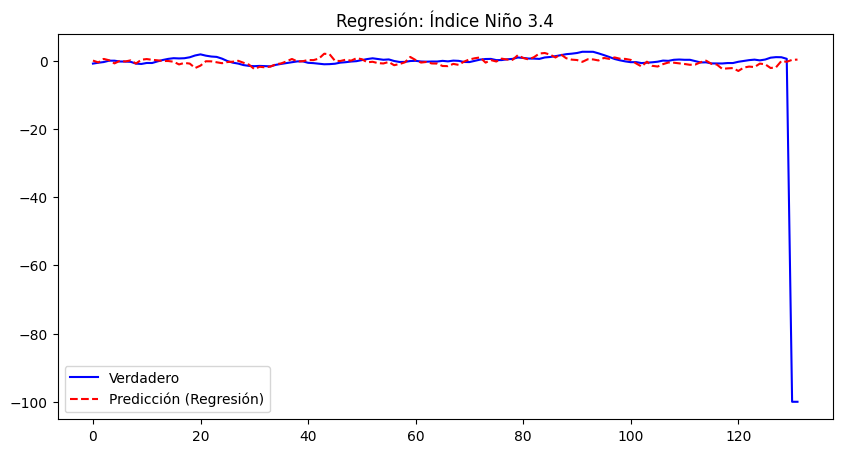

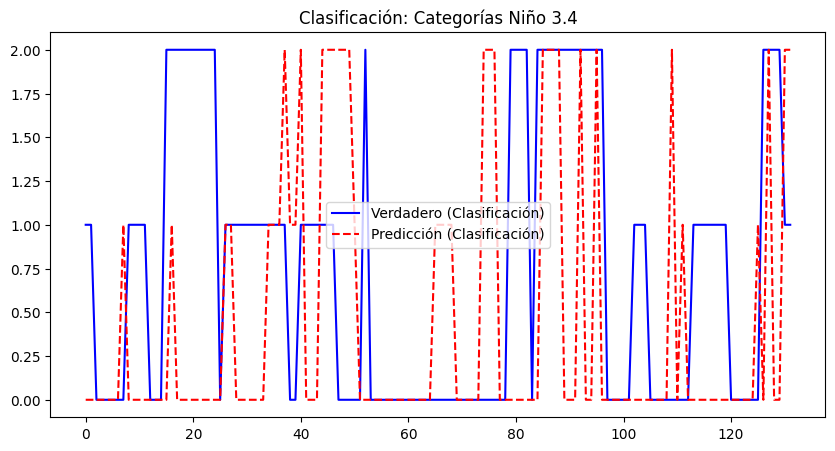

In [ ]:
# Gráfica de regresión
plt.figure(figsize=(10, 5))
plt.plot(y_test, label="Verdadero", color='blue')
plt.plot(y_pred_regr, '--', label="Predicción (Regresión)", color='red')
plt.title("Regresión: Índice Niño 3.4")
plt.legend()
plt.show()

# Gráfica de clasificación
plt.figure(figsize=(10, 5))
plt.plot(y_test_class, label="Verdadero (Clasificación)", color='blue')
plt.plot(y_pred_class, '--', label="Predicción (Clasificación)", color='red')
plt.title("Clasificación: Categorías Niño 3.4")
plt.legend()
plt.show()

## Ejercicio de desafío: ¡Obtenga el mejor algoritmo de pronóstico de ENSO! (Consejo: consulte la combinación entre algoritmos y pruebe el ajuste de hiperparámetros).

¿Son útiles las redes neuronales más profundas con más capas convolucionales?
Intente cambiar los hiperparámetros de la red neuronal

* tasa de aprendizaje
* la elección del optimizador
* el tamaño de los filtros de convolución
* la cantidad de filtros de convolución
* la cantidad de pesos en las capas completamente conectadas

Existen otros parámetros de preprocesamiento de datos que pueden mejorar el rendimiento de su algoritmo de pronóstico:

* entrenar su modelo de ML en una "porción" de latitud o longitud específica, en lugar de todo el globo
* ¡Combinar predicciones de múltiples algoritmos diferentes! Por ejemplo, podría promediar la predicción de bosques aleatorios, redes neuronales artificiales, redes neuronales convolucionales o cualquier otro modelo de aprendizaje automático.

Recuerde del cuaderno anterior: los modelos con muchos parámetros (es decir, redes neuronales muy profundas o árboles de decisión muy profundos) tienen más probabilidades de tener un sesgo muy bajo y una varianza muy alta: ¡es probable que se sobreajusten!

In [ ]:
# Importar librerías
import numpy as np
import pandas as pd
import xarray as xr
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset

# Configuración de parámetros
lead_time = 5
lat_slice = slice(-10, 10)  # Latitudes específicas
lon_slice = slice(120, 290)  # Longitudes específicas
num_input_time_steps = 3  # Número de pasos de tiempo de entrada
use_pca = True  # Usar PCA
n_components = 10  # Componentes para PCA
batch_size = 32  # Tamaño del lote para PyTorch
learning_rate = 0.001  # Tasa de aprendizaje
epochs = 10  # Número de épocas

In [ ]:
# Descargar archivos de datos
!wget -O sst.mon.mean.trefadj.anom.1880to2018.nc https://portal.nersc.gov/project/dasrepo/AGU_ML_Tutorial/sst.mon.mean.trefadj.anom.1880to2018.nc
!wget -O nino34.long.anom.data.txt https://portal.nersc.gov/project/dasrepo/AGU_ML_Tutorial/nino34.long.anom.data.txt

# Cargar el archivo SST (temperatura superficial del mar)
sst_data = xr.open_dataset('sst.mon.mean.trefadj.anom.1880to2018.nc')

# Cargar el archivo Niño 3.4
nino_data = pd.read_csv('nino34.long.anom.data.txt', skiprows=1, delim_whitespace=True, header=None)

# Verificar las dimensiones y un vistazo a los datos
print(sst_data)
print(nino_data.head())

--2025-01-15 03:45:41--  https://portal.nersc.gov/project/dasrepo/AGU_ML_Tutorial/sst.mon.mean.trefadj.anom.1880to2018.nc
Resolving portal.nersc.gov (portal.nersc.gov)... 128.55.206.106, 128.55.206.111, 128.55.206.112, ...
Connecting to portal.nersc.gov (portal.nersc.gov)|128.55.206.106|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 432481041 (412M) [application/x-netcdf]
Saving to: ‘sst.mon.mean.trefadj.anom.1880to2018.nc’

sst.mon.mean.trefad 100%[===================>] 412.45M  21.4MB/s    in 21s     

2025-01-15 03:46:03 (19.5 MB/s) - ‘sst.mon.mean.trefadj.anom.1880to2018.nc’ saved [432481041/432481041]

--2025-01-15 03:46:03--  https://portal.nersc.gov/project/dasrepo/AGU_ML_Tutorial/nino34.long.anom.data.txt
Resolving portal.nersc.gov (portal.nersc.gov)... 128.55.206.106, 128.55.206.107, 128.55.206.108, ...
Connecting to portal.nersc.gov (portal.nersc.gov)|128.55.206.106|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 15449 (15K

<ipython-input-8-8a566d140a1d>:9: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  nino_data = pd.read_csv('nino34.long.anom.data.txt', skiprows=1, delim_whitespace=True, header=None)


<xarray.Dataset> Size: 432MB
Dimensions:  (time: 1668, lon: 360, lat: 180)
Coordinates:
  * time     (time) datetime64[ns] 13kB 1880-01-16T12:00:00 ... 2018-12-16T12...
  * lon      (lon) float32 1kB 0.5 1.5 2.5 3.5 4.5 ... 356.5 357.5 358.5 359.5
  * lat      (lat) float32 720B 89.5 88.5 87.5 86.5 ... -86.5 -87.5 -88.5 -89.5
Data variables:
    sst      (time, lat, lon) float32 432MB ...
Attributes:
    CDI:              Climate Data Interface version 1.9.6 (http://mpimet.mpg...
    history:          Sun Jun 23 18:30:46 2019: cdo selyear,1880/2018 sst.mon...
    institution:      NOAA ESRL/PSD
    Conventions:      CF-1.2
    title:            created 12/2013 from data provided by JRA
    platform:         Analyses
    citation:         Hirahara, S., Ishii, M., and Y. Fukuda,2014: Centennial...
    References:       http://www.esrl.noaa.gov/psd/data/gridded/cobe2.html
    dataset_title:    COBE-SST2 Sea Surface Temperature and Ice
    original_source:  https://climate.mri-jma.go.jp/pu

In [ ]:
# Verificar latitudes y longitudes disponibles en el dataset
print("Latitudes disponibles en SST:", sst_data['lat'].values)
print("Longitudes disponibles en SST:", sst_data['lon'].values)

# Verificar rango temporal disponible
print("Fechas disponibles en SST:", sst_data['time'].values)

# Ajustar latitudes y longitudes si es necesario
# Se ajustan a un rango válido dentro del dataset
lat_slice = slice(-8.54199, 8.54199)  # Latitudes específicas ajustadas
lon_slice = slice(120, 290)  # Longitudes específicas (sin cambios, ya estaban dentro del rango)


Latitudes disponibles en SST: [ 89.5  88.5  87.5  86.5  85.5  84.5  83.5  82.5  81.5  80.5  79.5  78.5
  77.5  76.5  75.5  74.5  73.5  72.5  71.5  70.5  69.5  68.5  67.5  66.5
  65.5  64.5  63.5  62.5  61.5  60.5  59.5  58.5  57.5  56.5  55.5  54.5
  53.5  52.5  51.5  50.5  49.5  48.5  47.5  46.5  45.5  44.5  43.5  42.5
  41.5  40.5  39.5  38.5  37.5  36.5  35.5  34.5  33.5  32.5  31.5  30.5
  29.5  28.5  27.5  26.5  25.5  24.5  23.5  22.5  21.5  20.5  19.5  18.5
  17.5  16.5  15.5  14.5  13.5  12.5  11.5  10.5   9.5   8.5   7.5   6.5
   5.5   4.5   3.5   2.5   1.5   0.5  -0.5  -1.5  -2.5  -3.5  -4.5  -5.5
  -6.5  -7.5  -8.5  -9.5 -10.5 -11.5 -12.5 -13.5 -14.5 -15.5 -16.5 -17.5
 -18.5 -19.5 -20.5 -21.5 -22.5 -23.5 -24.5 -25.5 -26.5 -27.5 -28.5 -29.5
 -30.5 -31.5 -32.5 -33.5 -34.5 -35.5 -36.5 -37.5 -38.5 -39.5 -40.5 -41.5
 -42.5 -43.5 -44.5 -45.5 -46.5 -47.5 -48.5 -49.5 -50.5 -51.5 -52.5 -53.5
 -54.5 -55.5 -56.5 -57.5 -58.5 -59.5 -60.5 -61.5 -62.5 -63.5 -64.5 -65.5
 -66.5 -67.5 -68.5 -6

In [ ]:
def assemble_predictors_predictands(start_date, end_date, lead_time, lat_slice, lon_slice, num_input_time_steps, use_pca, n_components):
    # Filtrar SST según rango temporal y coordenadas
    sst = sst_data['sst'].sel(time=slice(start_date, end_date), lat=lat_slice, lon=lon_slice).fillna(0).values

    # Validar que las dimensiones sean válidas
    if sst.shape[1] == 0 or sst.shape[2] == 0:
        raise ValueError("El rango seleccionado de latitudes y longitudes no contiene datos válidos. Revisa lat_slice y lon_slice.")

    # Generar series temporales para los predictores
    predictors = []
    for i in range(len(sst) - num_input_time_steps - lead_time):
        predictors.append(sst[i:i + num_input_time_steps])
    predictors = np.array(predictors)

    # Validar predictores
    print("Shape de los predictores antes de PCA:", predictors.shape)
    if predictors.shape[0] == 0:
        raise ValueError("Los predictores están vacíos. Verifica el rango temporal y coordenadas.")

    # Generar predictandos (índice Niño 3.4)
    nino34 = nino_data.iloc[:, 1:].values.flatten()
    predictands = nino34[num_input_time_steps + lead_time: len(predictors) + num_input_time_steps + lead_time]

    # Reducción de dimensionalidad con PCA (opcional)
    if use_pca:
        n_components = min(n_components, predictors.shape[1] * predictors.shape[2])
        pca = PCA(n_components=n_components)
        predictors = pca.fit_transform(predictors.reshape(predictors.shape[0], -1))

    return predictors, predictands


In [ ]:
# Generar datos de entrenamiento y prueba
# 1. Seleccionar por tiempo y longitud
sst_subset = sst_data['sst'].sel(
    time=slice('1950-01-01', '2006-12-31'),
    lon=lon_slice
)

# 2. Obtener latitudes disponibles
available_lats = sst_subset['lat'].values

# 3. Encontrar latitudes más cercanas
lower_lat = available_lats[np.argmin(np.abs(available_lats - (-10)))]
upper_lat = available_lats[np.argmin(np.abs(available_lats - 10))]

# 4. Seleccionar con una lista de latitudes
sst = sst_subset.sel(
    lat=[lower_lat, upper_lat], # Usar una lista en lugar de slice
    #method="nearest"  # Ya no es necesario
).fillna(0).values

print("Shape del array SST para el rango seleccionado:", sst.shape)

# Ajustar coordenadas si no hay datos válidos
if sst.shape[1] == 0 or sst.shape[2] == 0:
    raise ValueError("El rango seleccionado de latitudes y longitudes no contiene datos válidos. Ajusta lat_slice y lon_slice.")

# Si no hay errores, proceder con la generación de predictores y predictandos
train_predictors, train_predictands = assemble_predictors_predictands(
    '1950-01-01', '2006-12-31', lead_time, [lower_lat, upper_lat], lon_slice, num_input_time_steps, use_pca, n_components
    # Se pasa [lower_lat, upper_lat] en lugar de lat_slice
)
test_predictors, test_predictands = assemble_predictors_predictands(
    '2007-01-01', '2017-12-31', lead_time, [lower_lat, upper_lat], lon_slice, num_input_time_steps, use_pca, n_components
    # Se pasa [lower_lat, upper_lat] en lugar de lat_slice
)

# Verificar formas de los datos generados
print("Shape de train_predictors:", train_predictors.shape)
print("Shape de train_predictands:", train_predictands.shape)

Shape del array SST para el rango seleccionado: (684, 2, 170)
Shape de los predictores antes de PCA: (676, 3, 2, 170)
Shape de los predictores antes de PCA: (124, 3, 2, 170)
Shape de train_predictors: (676, 6)
Shape de train_predictands: (676,)


In [ ]:
class ENSODataset(Dataset):
    def __init__(self, predictors, predictands):
        self.predictors = torch.tensor(predictors, dtype=torch.float32)
        self.predictands = torch.tensor(predictands, dtype=torch.float32)

    def __len__(self):
        return len(self.predictands)

    def __getitem__(self, idx):
        return self.predictors[idx], self.predictands[idx]

train_dataset = ENSODataset(train_predictors, train_predictands)
test_dataset = ENSODataset(test_predictors, test_predictands)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [ ]:
# Definir el modelo CNN
class ENSOCNN(nn.Module):
    def __init__(self, input_size):
        super(ENSOCNN, self).__init__()
        self.fc1 = nn.Linear(input_size, 64)
        self.fc2 = nn.Linear(64, 32)
        self.fc3 = nn.Linear(32, 1)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = self.fc3(x)
        return x

model = ENSOCNN(train_predictors.shape[1])

# Configuración del optimizador y la pérdida
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

# Entrenar el modelo
for epoch in range(epochs):
    model.train()
    train_loss = 0
    for predictors, predictands in train_loader:
        optimizer.zero_grad()
        outputs = model(predictors)
        loss = criterion(outputs.squeeze(), predictands)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
    print(f"Época {epoch + 1}/{epochs}, Pérdida de entrenamiento: {train_loss / len(train_loader):.4f}")


Época 1/10, Pérdida de entrenamiento: 0.6493
Época 2/10, Pérdida de entrenamiento: 0.5145
Época 3/10, Pérdida de entrenamiento: 0.4799
Época 4/10, Pérdida de entrenamiento: 0.4558
Época 5/10, Pérdida de entrenamiento: 0.4465
Época 6/10, Pérdida de entrenamiento: 0.4517
Época 7/10, Pérdida de entrenamiento: 0.4323
Época 8/10, Pérdida de entrenamiento: 0.3953
Época 9/10, Pérdida de entrenamiento: 0.3756
Época 10/10, Pérdida de entrenamiento: 0.3839


#EVALUACIÓN DEL MODELO

In [ ]:
# Evaluar el modelo en el conjunto de prueba
model.eval()
test_loss = 0
predictions = []
actuals = []

with torch.no_grad():
    for predictors, predictands in test_loader:
        outputs = model(predictors)
        test_loss += criterion(outputs.squeeze(), predictands).item()
        predictions.extend(outputs.squeeze().tolist())
        actuals.extend(predictands.tolist())

test_loss /= len(test_loader)
print(f"Pérdida en el conjunto de prueba: {test_loss:.4f}")

# Calcular métricas adicionales
from sklearn.metrics import mean_squared_error
from scipy.stats import pearsonr

mse = mean_squared_error(actuals, predictions)
corr, _ = pearsonr(actuals, predictions)

print(f"MSE en prueba: {mse:.4f}")
print(f"Correlación de Pearson en prueba: {corr:.4f}")


Pérdida en el conjunto de prueba: 0.8349
MSE en prueba: 0.8469
Correlación de Pearson en prueba: 0.0259


In [ ]:
# Entrenar un modelo Random Forest
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(train_predictors, train_predictands)

# Evaluar Random Forest
rf_predictions = rf_model.predict(test_predictors)
rf_mse = mean_squared_error(test_predictands, rf_predictions)
rf_corr, _ = pearsonr(test_predictands, rf_predictions)

print(f"MSE (Random Forest): {rf_mse:.4f}")
print(f"Correlación de Pearson (Random Forest): {rf_corr:.4f}")

MSE (Random Forest): 0.8744
Correlación de Pearson (Random Forest): -0.1297


In [ ]:
# Ensamblar predicciones (promedio simple)
ensemble_predictions = [(nn_pred + rf_pred) / 2 for nn_pred, rf_pred in zip(predictions, rf_predictions)]

# Evaluar el ensamblaje
ensemble_mse = mean_squared_error(test_predictands, ensemble_predictions)
ensemble_corr, _ = pearsonr(test_predictands, ensemble_predictions)

print(f"MSE (Ensemble): {ensemble_mse:.4f}")
print(f"Correlación de Pearson (Ensemble): {ensemble_corr:.4f}")

MSE (Ensemble): 0.8275
Correlación de Pearson (Ensemble): -0.0460


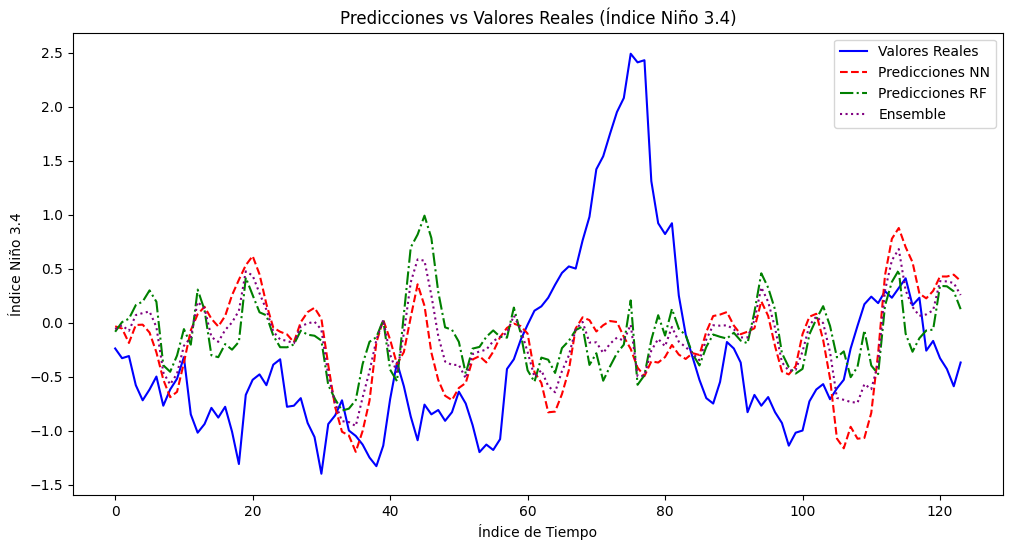

In [ ]:
import matplotlib.pyplot as plt

# Graficar resultados
plt.figure(figsize=(12, 6))
plt.plot(actuals, label='Valores Reales', color='blue')
plt.plot(predictions, label='Predicciones NN', color='red', linestyle='--')
plt.plot(rf_predictions, label='Predicciones RF', color='green', linestyle='-.')
plt.plot(ensemble_predictions, label='Ensemble', color='purple', linestyle=':')
plt.legend()
plt.title('Predicciones vs Valores Reales (Índice Niño 3.4)')
plt.xlabel('Índice de Tiempo')
plt.ylabel('Índice Niño 3.4')
plt.show()